In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode
import plotly.graph_objs as go
import math

init_notebook_mode(connected=True)

data_path_train = "res/AutoMPG.shuf.train.csv"
data_path_test = "res/AutoMPG.shuf.test.csv"
result_folder = "results/"

test_set_ratio=0.1

In [2]:
df_train = pd.read_csv(data_path_train)
df_test = pd.read_csv(data_path_test)
df_train.head(10) #199x10

,id,mpg,carName,cylinders,displacement,horsepower,weight,acceleration,modelYear,origin
0,37,19.0,ford torino 500,6,250.0,88,3302,15.5,71,1
1,312,32.1,chevrolet chevette,4,98.0,70,2120,15.5,80,1
2,29,9.0,hi 1200d,8,304.0,193,4732,18.5,70,1
3,330,44.6,honda civic 1500 gl,4,91.0,67,1850,13.8,80,3
4,71,13.0,chrysler newport royal,8,400.0,190,4422,12.5,72,1
5,38,18.0,amc matador,6,232.0,100,3288,15.5,71,1
6,280,29.5,honda accord lx,4,98.0,68,2135,16.6,78,3
7,68,11.0,mercury marquis,8,429.0,208,4633,11.0,72,1
8,308,26.8,oldsmobile omega brougham,6,173.0,115,2700,12.9,79,1
9,263,19.2,chevrolet monte carlo landau,8,305.0,145,3425,13.2,78,1


In [3]:
# overview over missing values
l_n_b = df_train.isnull().sum()>0
print(df_train.loc[:,l_n_b])
df_train.loc[:,l_n_b].isnull().sum()

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[199 rows x 0 columns]


Series([], dtype: float64)

In [4]:
# handle missing categorical values
cat_df_train = df_train.select_dtypes(include=['object']).copy()
cat_df_test = df_test.select_dtypes(include=['object']).copy()
#l_n_b = cat_df_train.isnull().sum()>0
#l_n_b_test = cat_df_test.isnull().sum()>0
# cat_df_data.loc[:,l_n_b].head(10) #only geocode2
#cat_df_data = cat_df_data.fillna('')
#cat_df_test = cat_df_test.fillna('')
# cat_df_data.loc[850:860,l_n_b]

from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
cat_df_train = cat_df_train.apply(enc.fit_transform) # categorical values - one hot encoding (73 object columns)
cat_df_test = cat_df_test.apply(enc.fit_transform)
cat_df_train.head(5)

,carName,horsepower
0,90,63
1,29,48
2,91,29
3,97,45
4,43,28


In [5]:
# handle missing numerical values
#from sklearn.preprocessing import Imputer
df_train_num = df_train.select_dtypes(include=['int64','float64'])
df_train_num = df_train_num.fillna(df_train_num.mean())

df_test_num = df_test.select_dtypes(include=['int64','float64'])
df_test_num = df_test_num.fillna(df_test_num.mean())

In [6]:
df_train = pd.concat([df_train_num, cat_df_train], axis=1)
df_test = pd.concat([df_test_num, cat_df_test], axis=1)
df_train.head(10)

,id,mpg,cylinders,displacement,weight,acceleration,modelYear,origin,carName,horsepower
0,37,19.0,6,250.0,3302,15.5,71,1,90,63
1,312,32.1,4,98.0,2120,15.5,80,1,29,48
2,29,9.0,8,304.0,4732,18.5,70,1,91,29
3,330,44.6,4,91.0,1850,13.8,80,3,97,45
4,71,13.0,8,400.0,4422,12.5,72,1,43,28
5,38,18.0,6,232.0,3288,15.5,71,1,8,0
6,280,29.5,4,98.0,2135,16.6,78,3,93,46
7,68,11.0,8,429.0,4633,11.0,72,1,107,31
8,308,26.8,6,173.0,2700,12.9,79,1,112,5
9,263,19.2,8,305.0,3425,13.2,78,1,35,16


In [7]:
df_train.describe()

,id,mpg,cylinders,displacement,weight,acceleration,modelYear,origin,carName,horsepower
count,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000
mean,193.527638,23.421608,5.497487,193.997487,2967.512563,15.331156,75.814070,1.532663,79.693467,35.467337
std,117.457355,7.853275,1.780575,106.633571,869.952662,2.826236,3.771317,0.763887,46.434721,22.376433
min,1.000000,9.000000,3.000000,68.000000,1649.000000,8.000000,70.000000,1.000000,0.000000,0.000000
25%,88.000000,17.000000,4.000000,98.000000,2203.500000,13.500000,73.000000,1.000000,38.500000,16.000000
50%,184.000000,23.500000,4.000000,146.000000,2725.000000,15.300000,76.000000,1.000000,80.000000,39.000000
75%,302.000000,28.900000,8.000000,302.000000,3631.000000,17.000000,79.000000,2.000000,118.000000,55.000000
max,398.000000,44.600000,8.000000,440.000000,4997.000000,24.800000,82.000000,3.000000,161.000000,70.000000


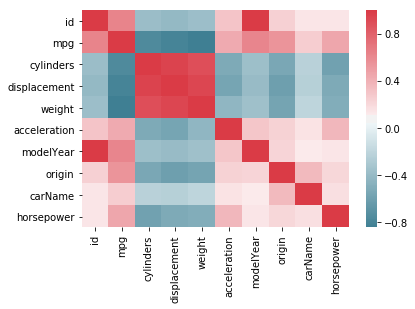

In [33]:
import seaborn as sns
%matplotlib inline

# calculate the correlation matrix
corr = df_train.corr()

cmap = sns.diverging_palette(220, 10, as_cmap=True)
# plot the heatmap
plot = sns.heatmap(corr, cmap=cmap,
        xticklabels=corr.columns,
        yticklabels=corr.columns)

plt.savefig('correlation_mpg.png', bbox_inches="tight")

In [58]:
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

pca = PCA()
X=df_train.loc[:, df_train.columns != 'mpg']
X=X.loc[:, X.columns != 'id']
X_reduced = pca.fit_transform(scale(X))
cs = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

D:\Program_Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning:

Data with input dtype int32, int64, float64 were all converted to float64 by the scale function.



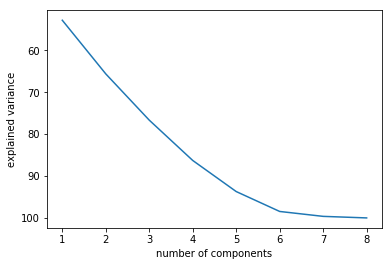

In [60]:
import matplotlib.pyplot as plt
x_coord = [i+1 for i in range (len(cs))]
plt.plot(x_coord,cs)
plt.gca().invert_yaxis()
plt.xlabel("number of components")
plt.ylabel("explained variance")
plt.savefig('pc_mpg.png')
plt.show()

## Baseline (mean mpg)

In [ ]:
pred = df_train['mpg'].median()
pred
df_res = pd.DataFrame()
df_res['id'] = df_test['id']

df_res['mpg'] = [pred for x in df_res['id']]
df_res.head(10)

#base_mse = mean_squared_error(df_test['TARGET_D'], [pred for x in df_test['id']])
#print("Baseline MSE: " + str(base_mse))
#print("RMSE: " + str(math.sqrt(base_mse)))

export_file_name = result_folder + "mpg_baseline.csv"
df_res.to_csv(export_file_name, index=False)

### Initialize Training data

In [9]:
df_vars = df_train.loc[:, df_train.columns != 'mpg']
df_vars = df_vars.loc[:, df_vars.columns != 'id']
df_class = df_train['mpg']
df_id = df_train['id']

X_train, X_test, y_train, y_test = train_test_split(df_vars, df_class, test_size=test_set_ratio, random_state=0)

In [10]:
X_test

,cylinders,displacement,weight,acceleration,modelYear,origin,carName,horsepower
18,6,258.0,3410,15.1,78,1,3,7
169,8,318.0,4457,13.5,74,1,58,19
106,8,400.0,4997,14.0,73,1,32,19
92,8,260.0,3365,15.5,78,1,110,2
176,8,318.0,4135,13.5,72,1,126,19
183,4,79.0,1963,15.5,74,2,154,45
5,6,232.0,3288,15.5,71,1,8,0
139,4,140.0,2408,19.5,72,1,39,64
12,4,90.0,2085,21.7,80,2,161,35
160,4,97.0,1985,16.4,77,3,145,45


In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.cross_decomposition import PLSRegression
from pandas import Series

df_vars_all = df_vars

#scaler = StandardScaler()
#df_vars_all = scaler.fit_transform(df_vars_all)

#reg = tree.DecisionTreeRegressor(min_samples_split=40)
#reg = linear_model.ElasticNet(alpha=0.0001,max_iter=10000)
#reg = RandomForestRegressor(n_estimators=100)
#reg = linear_model.Ridge()
#reg = linear_model.LinearRegression()
reg = PLSRegression(n_components=8)
scores = cross_validate(reg, df_vars, df_class, cv=10, scoring='neg_mean_squared_error')
scores

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning:

You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True



{'fit_time': array([0.0059998 , 0.00392818, 0.00400567, 0.00507569, 0.00399375,
        0.00392866, 0.00499845, 0.00500083, 0.00502181, 0.0049994 ]),
 'score_time': array([0.00200009, 0.00102234, 0.00092196, 0.00092411, 0.00100589,
        0.00199914, 0.00199986, 0.0020709 , 0.001055  , 0.00100017]),
 'test_score': array([-19.26512317, -10.93289155,  -4.66034618,  -9.14072057,
        -15.65144463,  -9.10661324, -11.0936604 ,  -6.10256304,
         -8.8364117 , -13.15022133]),
 'train_score': array([ -8.52469045,  -9.34878017, -10.02880398,  -9.61664235,
         -8.89531696,  -9.55276128,  -9.33972017,  -9.86074653,
         -9.61442465,  -9.21008743])}

### Model fitting and sample testing

In [28]:
model = reg.fit(X_train, y_train)
model.score(X_test, y_test)

0.831733113787222

In [29]:
model = reg.fit(df_vars, df_class)

### Final prediction

In [79]:
df_res = pd.DataFrame()
df_res['id'] = df_test['id']
#df_res['mpg'] = pd.Series(model.predict(df_test.loc[:,df_test.columns!='id']))
df_res['mpg'] = (model.predict(df_test.loc[:,df_test.columns!='id']))
df_res['mpg']

0      32.168060
1      32.644824
2      24.988419
3      29.439372
4      15.669632
5      17.286990
6      24.105886
7      29.038096
8      30.371840
9      11.766943
10     29.804053
11     25.117336
12     25.431977
13     34.809173
14     22.700187
15     30.514636
16     25.026156
17     26.123741
18     15.704426
19     28.009713
20     28.109692
21     20.974901
22     32.058724
23     23.705914
24     31.151635
25     29.740581
26     16.191492
27     30.577661
28     29.205379
29     35.352919
         ...    
169    31.759746
170    31.661007
171    22.558861
172    12.535499
173    20.901574
174    22.805908
175    30.094576
176    19.337668
177    16.634141
178    26.998172
179    28.005717
180    27.665157
181    22.280909
182    34.422399
183    21.130158
184    27.202415
185    16.465990
186    25.301564
187    27.250653
188    23.604751
189    23.697731
190    18.863149
191    34.953677
192    32.993840
193    19.366344
194    26.292183
195    21.197077
196    20.7121

In [83]:
df_res = pd.DataFrame()
df_res['id'] = df_test['id']
df_res['mpg'] = [31.81999374, 30.81042992, 22.67919479, 28.35805939, 16.09948586,
       16.82820213, 22.83219261, 30.17363861, 28.89562462, 13.73673763,
       29.60042358, 27.31172539, 24.12668564, 36.48363754, 19.92109421,
       27.4937748 , 24.00993782, 25.54883308, 15.3553183 , 27.73231987,
       25.85570435, 19.12122902, 28.09738907, 20.70718773, 30.08919968,
       27.06716141, 16.12677856, 29.23917564, 29.51490623, 37.33256821,
       33.16320999, 14.92055832, 24.95987511, 16.63593323, 25.69304367,
       19.09347862, 16.67553375, 30.62775764, 15.29174301, 28.08818863,
       12.79421356, 17.28332581, 14.12848488, 12.98091335, 13.73717213,
       23.32824715, 14.96523239, 27.26996384, 23.74998451, 25.096362  ,
       25.1044014 , 14.83050156, 36.56889816, 29.1646534 , 31.47614502,
       31.14660355, 17.19195206, 18.78615692, 36.75886292, 24.87309891,
       23.42956543, 14.96089478, 14.56302635, 25.49625496, 13.00506237,
       17.1185363 , 30.85255959, 17.70879494, 18.75836929, 20.15563049,
       24.76281387, 32.97246353, 27.58803314, 27.41499413, 23.86120033,
       14.12227989, 18.72879433, 15.85143112, 20.96866341, 33.9683815 ,
       19.07988258, 33.33402786, 14.69120201, 21.3262159 , 13.66387409,
       17.01282715, 25.05143448, 30.32815559, 20.87613869, 13.37534786,
       16.42833916, 25.03364044, 29.23638794, 19.30694939, 26.287967  ,
       30.28920341, 36.4056012 , 19.80508705, 17.24154312, 12.99021282,
       19.27349884, 28.64771751, 25.11295181, 21.60253868, 30.51010887,
       24.94729118, 20.26912163, 23.4860215 , 23.71332779, 36.62275055,
       19.90821724, 28.71577095, 34.05979065, 17.87619995, 24.70558723,
       21.67540169, 11.85379658, 28.85225395, 14.9616803 , 35.13571533,
       27.19344963, 28.99610611, 28.73494926, 33.29647888, 22.75061066,
       19.60102165, 22.35573769, 13.81695457, 23.363368  , 31.15512344,
       16.80014267, 24.7698111 , 23.27555252, 28.95029648, 20.20416351,
       29.28596962, 24.36659561, 22.28046104, 12.80288177, 35.87076447,
       25.74563576, 18.10247307, 18.22664001, 25.29994583, 15.19607254,
       26.38283829, 22.82195702, 16.65793274, 29.76108398, 12.92200397,
       23.86715813, 16.02619041, 22.62510574, 27.60822807, 29.18427475,
       13.29751339, 23.46124908, 37.59126907, 33.42454086, 24.3219825 ,
       19.11135948, 17.91015114, 21.83163994, 28.31813171, 26.53770889,
       24.94359726, 20.71028687, 24.05783844, 20.7077877 , 32.21495491,
       32.82921783, 20.43001839, 13.77060085, 20.50532494, 22.98011887,
       28.84222382, 18.64472847, 16.37530212, 24.92450653, 29.08046326,
       28.98707054, 22.87507729, 31.79764381, 19.34907715, 25.31492271,
       15.76581284, 24.87547203, 27.96063652, 23.59038361, 22.85883522,
       17.60636856, 35.22027664, 30.57095375, 17.20451675, 26.0843277 ,
       19.47792259, 19.37252174, 17.42871811, 18.67150909]
#df_res['mpg'] = (model.predict(df_test.loc[:,df_test.columns!='id']))
df_res.head(5)

,id,mpg
0,219,31.819994
1,322,30.810430
2,260,22.679195
3,168,28.358059
4,97,16.099486
5,223,16.828202
6,367,22.832193
7,239,30.173639
8,206,28.895625
9,92,13.736738


### Export

In [84]:
export_file_name = result_folder + "mpg_autompg_2.csv"
df_res.to_csv(export_file_name, index=False)

### Easy comparison

In [75]:
import traceback
from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import svm
from sklearn import preprocessing
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor, KDTree, BallTree
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import warnings
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)

df_vars_all = df_train.loc[:, df_train.columns != 'mpg']
df_class = df_train['mpg']

scaler = StandardScaler()
#df_vars_all = scaler.fit_transform(df_vars_all)

names = ["Linear", 
         "Elastic Net", 
         "PLS",
         "Decision Tree", 
         "Random Forest"]

classifiers = [
    linear_model.LinearRegression(),
    linear_model.ElasticNet(alpha=0.2, max_iter=10000),
    PLSRegression(n_components=8),
    tree.DecisionTreeRegressor(min_samples_split=40),
    RandomForestRegressor(n_estimators=50)
]

cl_scores = {}
df_vars = df_vars_all
scoring = {'mse': 'neg_mean_squared_error',
          'mae': 'neg_median_absolute_error'}

for name, clf in zip(names, classifiers):
    try:
        np.random.seed(32143421)
        scores = cross_validate(clf, df_vars_all, df_class, cv=10, scoring=scoring, return_train_score=True)
        cl_scores[name] = scores
        for score in scoring:
            print(name,"--",score,"-- Training Set --", "Mean", scores['train_'+score].mean(), "-- Min", scores['train_'+score].min(), "-- Max", scores['train_'+score].max())
            print(name,"--",score,"-- Test Set --", "Mean", scores['test_'+score].mean(), "-- Min", scores['test_'+score].min(), "-- Max", scores['test_'+score].max())
    except:
        print("Regression failed for", name)
        traceback.print_exc()

Linear -- mse -- Training Set -- Mean -9.342652945736457 -- Min -9.989239572711034 -- Max -8.49546381799443
Linear -- mse -- Test Set -- Mean -10.79226980577742 -- Min -19.058109194491347 -- Max -4.509683954887767
Linear -- mae -- Training Set -- Mean -2.0479187287161444 -- Min -2.1914341210221693 -- Max -1.8494112048385318
Linear -- mae -- Test Set -- Mean -2.272578655120232 -- Min -2.9256332227826114 -- Max -1.601477615555508
Elastic Net -- mse -- Training Set -- Mean -9.60671469613075 -- Min -10.249521453273703 -- Max -8.732005057637691
Elastic Net -- mse -- Test Set -- Mean -10.866926600744655 -- Min -19.8880951449052 -- Max -4.929298785087512
Elastic Net -- mae -- Training Set -- Mean -2.05886647876013 -- Min -2.1637762407605408 -- Max -1.9651710763784322
Elastic Net -- mae -- Test Set -- Mean -2.1802153776192266 -- Min -2.823078483066615 -- Max -1.33012719938721
PLS -- mse -- Training Set -- Mean -9.423011181803215 -- Min -10.054632183836107 -- Max -8.54590045222923
PLS -- mse --

In [45]:
import traceback
from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import svm
from sklearn import preprocessing
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor, KDTree, BallTree
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import warnings
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)

df_vars_all = df_train.loc[:, df_train.columns != 'mpg']
df_class = df_train['mpg']

scaler = StandardScaler()
df_vars_all = scaler.fit_transform(df_vars_all)

names = ["Linear", 
         "Ridge",
         "Elastic Net", 
         "PLS",
         "Decision Tree", 
         "Random Forest",
         "AdaBoost"]

classifiers = [
    linear_model.LinearRegression(),
    linear_model.Ridge(),
    linear_model.ElasticNet(),
    PLSRegression(),
    tree.DecisionTreeRegressor(min_samples_split=20),
    RandomForestRegressor(n_estimators=100),
    AdaBoostRegressor()
]

cl_scores = {}
df_vars = df_vars_all
scoring = {'mse': 'neg_mean_squared_error',
          'mae': 'neg_median_absolute_error'}

for name, clf in zip(names, classifiers):
    try:
        np.random.seed(32143421)
        scores = cross_validate(clf, df_vars_all, df_class, cv=10, scoring=scoring, return_train_score=True)
        cl_scores[name] = scores
        for score in scoring:
            print(name,"--",score,"-- Training Set --", "Mean", scores['train_'+score].mean(), "-- Min", scores['train_'+score].min(), "-- Max", scores['train_'+score].max())
            print(name,"--",score,"-- Test Set --", "Mean", scores['test_'+score].mean(), "-- Min", scores['test_'+score].min(), "-- Max", scores['test_'+score].max())
    except:
        print("Regression failed for", name)
        traceback.print_exc()

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.

D:\Program_Files\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning:

Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.



Linear -- mse -- Training Set -- Mean -9.342652945736454 -- Min -9.989239572711037 -- Max -8.495463817994425
Linear -- mse -- Test Set -- Mean -10.79226980577736 -- Min -19.05810919449117 -- Max -4.509683954887829
Linear -- mae -- Training Set -- Mean -2.0479187287161458 -- Min -2.191434121022212 -- Max -1.8494112048386295
Linear -- mae -- Test Set -- Mean -2.27257865512022 -- Min -2.9256332227825936 -- Max -1.6014776155555417
Ridge -- mse -- Training Set -- Mean -9.40785686995651 -- Min -10.045214208530803 -- Max -8.537602324687214
Ridge -- mse -- Test Set -- Mean -10.802247348104382 -- Min -19.818213062032513 -- Max -4.537243859195643
Ridge -- mae -- Training Set -- Mean -1.9948448222549466 -- Min -2.111084630444683 -- Max -1.8384606624528494
Ridge -- mae -- Test Set -- Mean -2.1730930130634407 -- Min -2.8434105759901005 -- Max -1.4742628780056517
Elastic Net -- mse -- Training Set -- Mean -13.379027962834371 -- Min -14.128348093431706 -- Max -11.969442850045985
Elastic Net -- mse --

### all features
Nearest Centroid -- Training Set -- Mean 0.7496791822186778 -- Min 0.7279005524861878 -- Max 0.7724039829302988
Nearest Centroid -- Test Set -- Mean 0.6628582456264915 -- Min 0.5873015873015873 -- Max 0.7543859649122807
Linear SVM -- Training Set -- Mean 1.0 -- Min 1.0 -- Max 1.0
Linear SVM -- Test Set -- Mean 0.9560670435070409 -- Min 0.9191919191919192 -- Max 1.0
Decision Tree -- Training Set -- Mean 1.0 -- Min 1.0 -- Max 1.0
Decision Tree -- Test Set -- Mean 0.9458952341983844 -- Min 0.9 -- Max 1.0
Naive Bayes -- Training Set -- Mean 1.0 -- Min 1.0 -- Max 1.0
Naive Bayes -- Test Set -- Mean 0.35593122949313594 -- Min 0.2727272727272727 -- Max 0.42857142857142855

In [76]:
import plotly.io as pio
traces = []
for clf_name in names:
    traces.append(go.Box(
        y=cl_scores[clf_name]['test_mse']*-1,
        boxpoints='all',
        name=clf_name
    ))
    
layout = go.Layout(title="MSE on Test Set (MPG)")
    
py.iplot(go.Figure(data=traces, layout=layout))
#pio.write_image(go.Figure(data=traces, layout=layout), 'mpg_boxplot_unscaled.pdf')
pio.write_image(go.Figure(data=traces, layout=layout), 'mpg_boxplot_tuned.png')

#### Auto sklearn

In [ ]:
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics

import autosklearn.regression

X_train = df_data.loc[:, df_data.columns != 'synth']
y_train = df_data['synth']

automl = autosklearn.regression.AutoSklearnRegressor(
       tmp_folder='/tmp/autosklearn_regression_example_tmp',
        output_folder='/tmp/autosklearn_regression_example_out',
    )
automl.fit(X_train, y_train, dataset_name='ghg')

print(automl.show_models())
predictions = automl.predict(X_test)
print("R2 score:", sklearn.metrics.mean_squared_error(y_test, predictions))

In [ ]:
from sklearn.feature_selection import f_regression
X = df_train.loc[:, df_train.columns != 'mpg']
y = df_train['mpg']

#Classifiers to be tested
names = ["Linear", #"Ridge",
         "Elastic Net", "PLS",
        "Decision Tree"#, "Random Forest",
        #"AdaBoost"
        ]

classifiers = [
    linear_model.LinearRegression(),
    #linear_model.Ridge(),
    linear_model.ElasticNet(),
    PLSRegression(),
    tree.DecisionTreeRegressor(min_samples_split=20)#,
    #RandomForestRegressor(n_estimators=100),
    #AdaBoostRegressor()
]
cl_scores = {}
for name in names:
    cl_scores[name] = []
scoring = {'mse': 'neg_mean_squared_error',
          'mae': 'neg_median_absolute_error'}


for feature_count in [2,3,4,5,9]:
    X_selected = SelectKBest(f_regression, k=feature_count).fit_transform(X,y)
    print("----------------------------------")    
    print("Feature count=", feature_count)
    for name, clf in zip(names, classifiers):
        try:
            np.random.seed(32143421)
            scores = cross_validate(clf, X_selected, y, cv=10, scoring=scoring, return_train_score=True)
            cl_scores[name].append(scores)
            for score in scoring:
                print(name,"--",score,"-- Training Set --", "Mean", scores['train_'+score].mean(), "-- Min", scores['train_'+score].min(), "-- Max", scores['train_'+score].max())
                print(name,"--",score,"-- Test Set --", "Mean", scores['test_'+score].mean(), "-- Min", scores['test_'+score].min(), "-- Max", scores['test_'+score].max())
        except:
            print("Classification failed for", name)
            traceback.print_exc()

In [ ]:
names = ["Linear", #"Ridge",
         "Elastic Net", "PLS",
        "Decision Tree"#, "Random Forest",
        #"AdaBoost"
        ]
trace=[]

classifiers = [
    linear_model.LinearRegression(),
    #linear_model.Ridge(),
    linear_model.ElasticNet(),
    PLSRegression(),
    tree.DecisionTreeRegressor(min_samples_split=20)#,
    #RandomForestRegressor(n_estimators=100),
    #AdaBoostRegressor()
]
feature_counts = [2,3,4,5,9]
for idx, feature_count in enumerate(feature_counts):
    for cl in names:
        for score in cl_scores[cl][idx]['test_mse']:
            trace.append({'score': score, 'x':idx, 'name':feature_count , 'classifier':cl})
df_mpg = pd.DataFrame.from_dict(trace)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
g = sns.relplot(x="x", y="score", kind="line", hue="classifier", style="classifier", data=df_mpg)
plt.xticks(range(len(feature_counts)), feature_counts, rotation='vertical')
plt.xlabel("Feature counts")
plt.title("10-fold CV Accuracy scores by Feature count")
axes = plt.gca()
#axes.set_ylim([0.5,0.61])
#axes.set_xlim([0,len(feature_counts)])
plt.savefig('feature_cnt_eval_mpg.pdf')
plt.show()

### Hyper parameter 

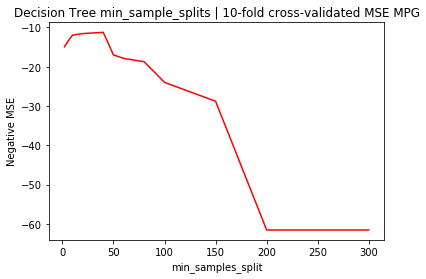

In [72]:
min_samples_splits = [2,7,10,20,40,50,60,80,90,100,150,200,300]
scoring = {'mse': 'neg_mean_squared_error'}
results = []
X = df_train.loc[:, df_train.columns != 'mpg']
X = X.loc[:,X.columns!='id']
y = df_train['mpg']
for min_samples_split in min_samples_splits:
    clf = tree.DecisionTreeRegressor(min_samples_split=min_samples_split)
    scores = cross_validate(clf, X, y, cv=10, scoring=scoring, return_train_score=True)
    results.append(scores['test_mse'].mean())
    
plt.plot(min_samples_splits, results, "r", label="Test Accuracy")
plt.ylabel("Negative MSE")
plt.xlabel("min_samples_split")
plt.title("Decision Tree min_sample_splits | 10-fold cross-validated MSE MPG")
plt.savefig('mpg_dt_hypertuning.png')
plt.show()

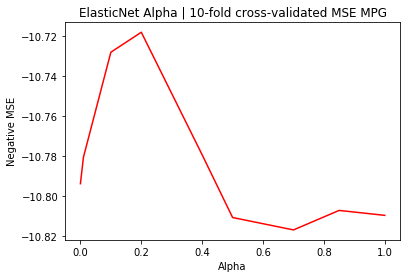

In [71]:
C = [0.00001, 0.0001, 0.001, 0.01, 0.1,0.2,0.4,0.5,0.7,0.85, 1]
scoring = {'mse': 'neg_mean_squared_error'}
results = []
X = df_train.loc[:, df_train.columns != 'mpg']
X = X.loc[:,X.columns!='id']
y = df_train['mpg']
for cs in C:
    clf = linear_model.ElasticNet(alpha=cs,max_iter=10000)
    scores = cross_validate(clf, X, y, cv=10, scoring=scoring, return_train_score=True)
    results.append(scores['test_mse'].mean())
    
plt.plot(C, results, "r", label="Test Accuracy")
plt.ylabel("Negative MSE")
plt.xlabel("Alpha")
plt.title("ElasticNet Alpha | 10-fold cross-validated MSE MPG")
plt.savefig('mpg_alpha_elasticnet.png',bbox_inches="tight")
plt.show()

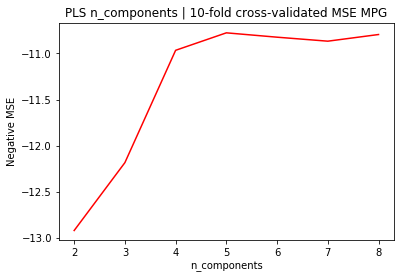

In [51]:
C = [2,3,4,5,6,7,8]
scoring = {'mse': 'neg_mean_squared_error'}
results = []
X = df_train.loc[:, df_train.columns != 'mpg']
X = X.loc[:,X.columns!='id']
y = df_train['mpg']
for cs in C:
    clf = PLSRegression(n_components=cs)
    scores = cross_validate(clf, X, y, cv=10, scoring=scoring, return_train_score=True)
    results.append(scores['test_mse'].mean())
    
plt.plot(C, results, "r", label="Test Accuracy")
plt.ylabel("Negative MSE")
plt.xlabel("n_components")
plt.title("PLS n_components | 10-fold cross-validated MSE MPG")
plt.savefig('mpg_ncomponents_pls.png')
plt.show()

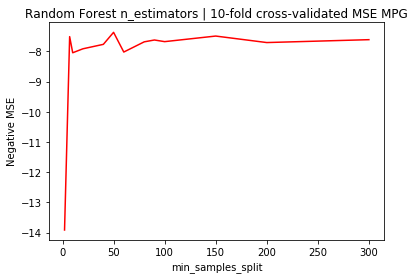

In [77]:
estimators = [2,7,10,20,40,50,60,80,90,100,150,200,300]
scoring = {'mse': 'neg_mean_squared_error'}
results = []
X = df_train.loc[:, df_train.columns != 'mpg']
X = X.loc[:,X.columns!='id']
y = df_train['mpg']
for estimator in estimators:
    clf = RandomForestRegressor(n_estimators=estimator)
    scores = cross_validate(clf, X, y, cv=10, scoring=scoring, return_train_score=True)
    results.append(scores['test_mse'].mean())
    
plt.plot(estimators, results, "r", label="Test Accuracy")
plt.ylabel("Negative MSE")
plt.xlabel("min_samples_split")
plt.title("Random Forest n_estimators | 10-fold cross-validated MSE MPG")
plt.savefig('mpg_rf_hypertuning.png')
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
corr = df_vars.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
trace = []
names = ["Nearest Centroid", "Linear SVM",
         "Decision Tree", "Naive Bayes"]
feature_counts = [1,2,5,10,20,30,40,50,100,500,1000,10000]#, "All"]
for idx, feature_count in enumerate(feature_counts):
    for cl in names:
        for score in cl_scores[cl][idx]['test_score']:
            trace.append({'score': score, 'x':idx, 'name':feature_count, 'classifier':cl})
df_trace = pd.DataFrame.from_dict(trace)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
g = sns.relplot(x="x", y="score", kind="line", hue="classifier", style="classifier", data=df_trace)
plt.xticks(range(len(feature_counts)), feature_counts, rotation='vertical')
plt.xlabel("Feature counts")
plt.title("10-fold CV Accuracy scores by Feature count (removing ID)")
axes = plt.gca()
axes.set_ylim([0.0,0.6])
axes.set_xlim([0,len(feature_counts)])
plt.savefig('feature_cnt_eval_wo_ID.pdf')
plt.show()

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

df_vars_all = df_train.loc[:, df_train.columns != 'Class']
#df_vars_all = df_vars_all.drop('ID', axis=1)
df_class = df_train['Class']
selector = SelectKBest(chi2, k=1)
selector.fit(df_vars_all, df_class)
cols = selector.get_support(indices=True)
best_features = df_vars_all.columns[cols]
#df_vars = SelectKBest(chi2, k=1).fit_transform(df_vars_all, df_class)
best_features

In [ ]:
df_train.columns

In [ ]:
class_labels = sorted(df_train['Class'].unique(), key=lambda s: s.lower())
df_res = pd.DataFrame()
df_res['CONTROLN'] = df_test['CONTROLN']
df_res['TARGET_D'] = df_test['CONTROLN'].apply(lambda x: class_labels[(x-1)//30])
df_res.head(10)

In [ ]:
export_file_name = result_folder + "kdd_prediction.csv"
df_res.to_csv(export_file_name, index=False)